In [1]:
import os, sys, time
import itertools
import imageio
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from dataset import get_data
from scipy.misc import imsave
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils as utils
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as v_utils

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
class arguments():
    def __init__(self):
        self.dataset = 'CelebA'
        self.dataroot = '/data/jehyuk/imgdata'
        self.workers = 2
        self.n_gpu = 1
        self.batchsize = 64
        self.maxepoch = 100
        self.imagesize = 64
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.channel_bunch = 64
        self.use_cuda = True
        self.n_z = 64
        self.result_dir = '/home/jehyuk/GenerativeModels/GAN/results/WGAN/' + self.dataset
        self.save_dir = '/home/jehyuk/GenerativeModels/GAN/models/WGAN' + self.dataset
        self.n_sample = 16

opt = arguments()

In [5]:
def load_dataset(dataroot = opt.dataroot, dataset=opt.dataset):
    data_folder = os.path.join(dataroot, dataset)
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    transform = transforms.Compose([transforms.Scale(opt.imagesize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    if dataset == 'MNIST':
        trn_data = dset.MNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.MNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'Fashion-MNIST':
        trn_data = dset.FashionMNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.FashionMNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'CIFAR10':
        trn_data = dset.cifar.CIFAR10(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.cifar.CIFAR10(data_folder, train=False, transform=transform, download=True)
        n_channels = 3
    elif dataset == 'CelebA':
        trn_data = get_data(data_folder, split='train', image_size=opt.imagesize)
        tst_data = get_data(data_folder, split='test', image_size=opt.imagesize)
        n_channels = 3
    trn_loader = utils.data.DataLoader(trn_data, batch_size=opt.batchsize, shuffle=True, num_workers=opt.workers, drop_last=True)
    tst_loader = utils.data.DataLoader(tst_data, batch_size=opt.batchsize, shuffle=False, num_workers=opt.workers, drop_last=True)
    return trn_loader, tst_loader, n_channels

In [6]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
#         m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

def save_images(images, size, image_path):
    image = np.squeeze(merge(images, size))
    return imsave(image_path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')


In [7]:
class Discriminator(nn.Module):
    def __init__(self, opt, n_channels):
        super(Discriminator, self).__init__()
        self.n_z = opt.n_z
        self.channel_bunch = opt.channel_bunch
        self.n_channels = n_channels
        
        layers = nn.Sequential()
        
        layers.add_module("Conv1", nn.Conv2d(self.n_channels, self.channel_bunch, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Activation1", nn.LeakyReLU(negative_slope=0.2))
        
        layers.add_module("Conv2", nn.Conv2d(self.channel_bunch, self.channel_bunch*2, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm2", nn.BatchNorm2d(self.channel_bunch*2))
        layers.add_module("Activation2", nn.LeakyReLU(negative_slope=0.2))

        layers.add_module("Conv3", nn.Conv2d(self.channel_bunch*2, self.channel_bunch*4, kernel_size=4, stride=2, padding=1, bias=False)) 
        layers.add_module("Batchnorm3", nn.BatchNorm2d(self.channel_bunch*4))
        layers.add_module("Activation3", nn.LeakyReLU(negative_slope=0.2))

        layers.add_module("Conv4", nn.Conv2d(self.channel_bunch*4, self.channel_bunch*8, kernel_size=4, stride=2, padding=1, bias=False)) 
        layers.add_module("Batchnorm4", nn.BatchNorm2d(self.channel_bunch*8))
        layers.add_module("Activation4", nn.LeakyReLU(negative_slope=0.2))

        layers.add_module("Conv5", nn.Conv2d(self.channel_bunch*8, 1, kernel_size=4, stride=1, padding=0, bias=False))
        layers.add_module("Activation5", nn.Sigmoid())

        self.layers = layers
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [8]:
class Generator(nn.Module):
    def __init__(self, opt, n_channels):
        super(Generator, self).__init__()
        self.n_z = opt.n_z
        self.channel_bunch = opt.channel_bunch
        self.n_channels = n_channels

        layers = nn.Sequential()

        layers.add_module("TransConv1", nn.ConvTranspose2d(self.n_z, self.channel_bunch*8, kernel_size=4, stride=1, padding=0, bias=False))
        layers.add_module("Batchnorm1", nn.BatchNorm2d(self.channel_bunch*8))
        layers.add_module("Activation1", nn.ReLU(inplace=True))

        layers.add_module("TransConv2", nn.ConvTranspose2d(self.channel_bunch*8, self.channel_bunch*4, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm2", nn.BatchNorm2d(self.channel_bunch*4))
        layers.add_module("Activation2", nn.ReLU(inplace=True))

        layers.add_module("TransConv3", nn.ConvTranspose2d(self.channel_bunch*4, self.channel_bunch*2, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm3", nn.BatchNorm2d(self.channel_bunch*2))
        layers.add_module("Activation3", nn.ReLU(inplace=True))

        layers.add_module("TransConv4", nn.ConvTranspose2d(self.channel_bunch*2, self.channel_bunch, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Batchnorm4", nn.BatchNorm2d(self.channel_bunch))
        layers.add_module("Actvation4", nn.ReLU(inplace=True))
    
        layers.add_module("TransConv5", nn.ConvTranspose2d(self.channel_bunch, self.n_channels, kernel_size=4, stride=2, padding=1, bias=False))
        layers.add_module("Actvation5", nn.Tanh())
    
        self.layers = layers
        
    def forward(self, z):
        x = self.layers(z)
        return x

In [ ]:
class WGAN(object):
    def __init__(self, opt):

        self.opt = opt
        self.trn_loader, self.tst_loader, self.n_channels = load_dataset(self.opt.dataroot, self.opt.dataset)
        self.is_cuda = torch.cuda.is_available()

        self.G = Generator(self.opt, self.n_channels)
        self.D = Discriminator(self.opt, self.n_channels)
        self.G.apply(initialize_weights)
        self.D.apply(initialize_weights)
        self.sample_z = Variable(torch.rand((self.opt.n_sample, self.opt.n_z, 1, 1)), volatile=True)
                
        if self.is_cuda and self.opt.use_cuda:
            self.G, self.D = self.G.cuda(), self.D.cuda()
            self.sample_z = self.sample_z.cuda()
        self.optim_G = torch.optim.RMSprop(params=self.G.parameters(), lr=self.opt.lrG)
        self.optim_D = torch.optim.RMSprop(params=self.D.parameters(), lr=self.opt.lrD)
    
    def train(self):
        self.loss_dict=dict()
        self.loss_dict['G_loss'], self.loss_dict['D_fake_loss'], self.loss_dict['D_real_loss'] = list(), list(), list()

        self.D.train()
        print('------------------Start training------------------')
        for epoch in range(self.opt.maxepoch):
            self.G.train()
            print(">>>>Epoch: {}".format(epoch+1))
            start_time = time.time()
            for iter_num, (image, label) in enumerate(self.trn_loader):
                x = Variable(image)
                z1 = Variable(torch.rand((self.opt.batchsize, self.opt.n_z, 1, 1)))
                z2 = Variable(torch.rand((self.opt.batchsize, self.opt.n_z, 1, 1)))
                true_label = Variable(torch.ones(self.opt.batchsize, 1))
                fake_label = Variable(torch.zeros(self.opt.batchsize, 1))
                if self.is_cuda:
                    x, z1, z2 = x.cuda(), z1.cuda(), z2.cuda()
                    true_label, fake_label = true_label.cuda(), fake_label.cuda()
                
                # Train D
                self.optim_D.zero_grad()
                D_x = self.D.forward(x)
                D_x = D_x.squeeze()
                
                G_z = self.G.forward(z1)
                D_G_z = self.D.forward(G_z)
                D_G_z = D_G_z.squeeze()
                
                D_real_loss = -torch.mean(D_x)
                D_fake_loss = torch.mean(D_G_z)
                D_loss = D_real_loss + D_fake_loss
                D_loss.backward()
                self.optim_D.step()
                for param in self.D.parameters():
                    param.data.clamp_(-0.01, 0.01)
                
                #Train G
                if (iter_num + 1) % 5 == 0:
                    self.optim_G.zero_grad()
                    G_z = self.G.forward(z2)
                    D_G_z = self.D.forward(G_z)
                    D_G_z = D_G_z.squeeze()
                    G_loss = -torch.mean(D_G_z)
                    G_loss.backward()
                    self.optim_G.step()

                if (iter_num+1) % 100 == 0:
                    print("Epoch: {}, iter: {}, D_real_loss: {:.3f}, D_fake_loss: {:.3f}, G_loss: {:.3f}".format(epoch+1, iter_num+1, -D_real_loss.data[0], D_fake_loss.data[0], -G_loss.data[0]))
                    self.loss_dict['G_loss'].append(G_loss.data[0])
                    self.loss_dict['D_fake_loss'].append(D_fake_loss.data[0])
                    self.loss_dict['D_real_loss'].append(D_real_loss.data[0])
            print(">>>>Time for 1 epoch: {:.2f}".format(time.time()-start_time))
            self.save_results(epoch+1, self.sample_z)
        self.save_model()
            
    def save_results(self, epoch, sample):
        self.G.eval()
        if not os.path.exists(self.opt.result_dir):
            os.makedirs(self.opt.result_dir)
        fake_file_name = self.opt.result_dir + '/WGAN_epoch%03d' %epoch + '.png'
        fake_results = self.G.forward(sample)
        v_utils.save_image(fake_results.data, fake_file_name, nrow = int(math.sqrt(self.opt.n_sample)), normalize=True)

    def save_model(self):
        if not os.path.exists(self.opt.save_dir):
            os.makedirs(self.opt.save_dir)
        torch.save(self.G.state_dict(), os.path.join(self.opt.save_dir, 'G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(self.opt.save_dir, 'D.pkl'))
        with open(os.path.join(self.opt.save_dir, 'loss_dict'), 'wb') as f:
            pickle.dump(self.loss_dict, f)
    
    def load_model(self):
        self.G.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'D.pkl')))

In [ ]:
wgan = WGAN(opt)
wgan.train()

Found 162770 images in subfolders of: /data/jehyuk/imgdata/CelebA/splits/train
Found 19962 images in subfolders of: /data/jehyuk/imgdata/CelebA/splits/test
------------------Start training------------------
>>>>Epoch: 1
Epoch: 1, iter: 100, D_real_loss: 0.556, D_fake_loss: 0.419, G_loss: 0.406
Epoch: 1, iter: 200, D_real_loss: 0.596, D_fake_loss: 0.407, G_loss: 0.368
Epoch: 1, iter: 300, D_real_loss: 0.612, D_fake_loss: 0.369, G_loss: 0.353
Epoch: 1, iter: 400, D_real_loss: 0.636, D_fake_loss: 0.364, G_loss: 0.358
Epoch: 1, iter: 500, D_real_loss: 0.636, D_fake_loss: 0.360, G_loss: 0.353
Epoch: 1, iter: 600, D_real_loss: 0.632, D_fake_loss: 0.369, G_loss: 0.358
Epoch: 1, iter: 700, D_real_loss: 0.610, D_fake_loss: 0.352, G_loss: 0.357
Epoch: 1, iter: 800, D_real_loss: 0.618, D_fake_loss: 0.343, G_loss: 0.367
Epoch: 1, iter: 900, D_real_loss: 0.650, D_fake_loss: 0.349, G_loss: 0.348
Epoch: 1, iter: 1000, D_real_loss: 0.649, D_fake_loss: 0.347, G_loss: 0.342
Epoch: 1, iter: 1100, D_real_

Epoch: 5, iter: 500, D_real_loss: 0.539, D_fake_loss: 0.367, G_loss: 0.480
Epoch: 5, iter: 600, D_real_loss: 0.638, D_fake_loss: 0.384, G_loss: 0.360
Epoch: 5, iter: 700, D_real_loss: 0.523, D_fake_loss: 0.363, G_loss: 0.452
Epoch: 5, iter: 800, D_real_loss: 0.550, D_fake_loss: 0.373, G_loss: 0.502
Epoch: 5, iter: 900, D_real_loss: 0.641, D_fake_loss: 0.408, G_loss: 0.363
Epoch: 5, iter: 1000, D_real_loss: 0.637, D_fake_loss: 0.418, G_loss: 0.363
Epoch: 5, iter: 1100, D_real_loss: 0.627, D_fake_loss: 0.445, G_loss: 0.365
Epoch: 5, iter: 1200, D_real_loss: 0.520, D_fake_loss: 0.367, G_loss: 0.481
Epoch: 5, iter: 1300, D_real_loss: 0.635, D_fake_loss: 0.496, G_loss: 0.372
Epoch: 5, iter: 1400, D_real_loss: 0.632, D_fake_loss: 0.423, G_loss: 0.368
Epoch: 5, iter: 1500, D_real_loss: 0.623, D_fake_loss: 0.461, G_loss: 0.370
Epoch: 5, iter: 1600, D_real_loss: 0.630, D_fake_loss: 0.475, G_loss: 0.374
Epoch: 5, iter: 1700, D_real_loss: 0.531, D_fake_loss: 0.376, G_loss: 0.472
Epoch: 5, iter: 1

Epoch: 9, iter: 1200, D_real_loss: 0.482, D_fake_loss: 0.383, G_loss: 0.524
Epoch: 9, iter: 1300, D_real_loss: 0.532, D_fake_loss: 0.401, G_loss: 0.490
Epoch: 9, iter: 1400, D_real_loss: 0.513, D_fake_loss: 0.400, G_loss: 0.500
Epoch: 9, iter: 1500, D_real_loss: 0.617, D_fake_loss: 0.487, G_loss: 0.373
Epoch: 9, iter: 1600, D_real_loss: 0.567, D_fake_loss: 0.430, G_loss: 0.418
Epoch: 9, iter: 1700, D_real_loss: 0.514, D_fake_loss: 0.399, G_loss: 0.484
Epoch: 9, iter: 1800, D_real_loss: 0.523, D_fake_loss: 0.395, G_loss: 0.514
Epoch: 9, iter: 1900, D_real_loss: 0.590, D_fake_loss: 0.460, G_loss: 0.389
Epoch: 9, iter: 2000, D_real_loss: 0.513, D_fake_loss: 0.390, G_loss: 0.506
Epoch: 9, iter: 2100, D_real_loss: 0.501, D_fake_loss: 0.394, G_loss: 0.510
Epoch: 9, iter: 2200, D_real_loss: 0.608, D_fake_loss: 0.508, G_loss: 0.385
Epoch: 9, iter: 2300, D_real_loss: 0.469, D_fake_loss: 0.398, G_loss: 0.481
Epoch: 9, iter: 2400, D_real_loss: 0.596, D_fake_loss: 0.445, G_loss: 0.383
Epoch: 9, it

Epoch: 13, iter: 1700, D_real_loss: 0.547, D_fake_loss: 0.446, G_loss: 0.450
Epoch: 13, iter: 1800, D_real_loss: 0.604, D_fake_loss: 0.511, G_loss: 0.387
Epoch: 13, iter: 1900, D_real_loss: 0.588, D_fake_loss: 0.499, G_loss: 0.387
Epoch: 13, iter: 2000, D_real_loss: 0.469, D_fake_loss: 0.391, G_loss: 0.539
Epoch: 13, iter: 2100, D_real_loss: 0.592, D_fake_loss: 0.492, G_loss: 0.377
Epoch: 13, iter: 2200, D_real_loss: 0.462, D_fake_loss: 0.389, G_loss: 0.514
Epoch: 13, iter: 2300, D_real_loss: 0.466, D_fake_loss: 0.395, G_loss: 0.510
Epoch: 13, iter: 2400, D_real_loss: 0.475, D_fake_loss: 0.406, G_loss: 0.499
Epoch: 13, iter: 2500, D_real_loss: 0.595, D_fake_loss: 0.522, G_loss: 0.390
>>>>Time for 1 epoch: 131.82
>>>>Epoch: 14
Epoch: 14, iter: 100, D_real_loss: 0.501, D_fake_loss: 0.400, G_loss: 0.547
Epoch: 14, iter: 200, D_real_loss: 0.479, D_fake_loss: 0.400, G_loss: 0.523
Epoch: 14, iter: 300, D_real_loss: 0.586, D_fake_loss: 0.478, G_loss: 0.387
Epoch: 14, iter: 400, D_real_loss: 0

Epoch: 17, iter: 2200, D_real_loss: 0.498, D_fake_loss: 0.420, G_loss: 0.536
Epoch: 17, iter: 2300, D_real_loss: 0.560, D_fake_loss: 0.468, G_loss: 0.423
Epoch: 17, iter: 2400, D_real_loss: 0.515, D_fake_loss: 0.431, G_loss: 0.500
Epoch: 17, iter: 2500, D_real_loss: 0.511, D_fake_loss: 0.426, G_loss: 0.508
>>>>Time for 1 epoch: 126.97
>>>>Epoch: 18
Epoch: 18, iter: 100, D_real_loss: 0.535, D_fake_loss: 0.448, G_loss: 0.465
Epoch: 18, iter: 200, D_real_loss: 0.510, D_fake_loss: 0.431, G_loss: 0.528
Epoch: 18, iter: 300, D_real_loss: 0.462, D_fake_loss: 0.402, G_loss: 0.526
Epoch: 18, iter: 400, D_real_loss: 0.474, D_fake_loss: 0.412, G_loss: 0.513
Epoch: 18, iter: 500, D_real_loss: 0.477, D_fake_loss: 0.405, G_loss: 0.561
Epoch: 18, iter: 600, D_real_loss: 0.477, D_fake_loss: 0.407, G_loss: 0.534
Epoch: 18, iter: 700, D_real_loss: 0.482, D_fake_loss: 0.421, G_loss: 0.511
Epoch: 18, iter: 800, D_real_loss: 0.470, D_fake_loss: 0.404, G_loss: 0.548
Epoch: 18, iter: 900, D_real_loss: 0.598,

Epoch: 22, iter: 200, D_real_loss: 0.483, D_fake_loss: 0.407, G_loss: 0.550
Epoch: 22, iter: 300, D_real_loss: 0.444, D_fake_loss: 0.401, G_loss: 0.519
Epoch: 22, iter: 400, D_real_loss: 0.454, D_fake_loss: 0.393, G_loss: 0.553
Epoch: 22, iter: 500, D_real_loss: 0.449, D_fake_loss: 0.398, G_loss: 0.543
Epoch: 22, iter: 600, D_real_loss: 0.486, D_fake_loss: 0.430, G_loss: 0.503
Epoch: 22, iter: 700, D_real_loss: 0.478, D_fake_loss: 0.415, G_loss: 0.575
Epoch: 22, iter: 800, D_real_loss: 0.573, D_fake_loss: 0.498, G_loss: 0.408
Epoch: 22, iter: 900, D_real_loss: 0.577, D_fake_loss: 0.505, G_loss: 0.405
Epoch: 22, iter: 1000, D_real_loss: 0.556, D_fake_loss: 0.479, G_loss: 0.430
Epoch: 22, iter: 1100, D_real_loss: 0.485, D_fake_loss: 0.420, G_loss: 0.537
Epoch: 22, iter: 1200, D_real_loss: 0.483, D_fake_loss: 0.411, G_loss: 0.534
Epoch: 22, iter: 1300, D_real_loss: 0.476, D_fake_loss: 0.419, G_loss: 0.558
Epoch: 22, iter: 1400, D_real_loss: 0.597, D_fake_loss: 0.541, G_loss: 0.406
Epoch: 

Epoch: 26, iter: 700, D_real_loss: 0.581, D_fake_loss: 0.530, G_loss: 0.401
Epoch: 26, iter: 800, D_real_loss: 0.441, D_fake_loss: 0.410, G_loss: 0.481
Epoch: 26, iter: 900, D_real_loss: 0.455, D_fake_loss: 0.410, G_loss: 0.521
Epoch: 26, iter: 1000, D_real_loss: 0.443, D_fake_loss: 0.404, G_loss: 0.539
Epoch: 26, iter: 1100, D_real_loss: 0.595, D_fake_loss: 0.540, G_loss: 0.397
Epoch: 26, iter: 1200, D_real_loss: 0.553, D_fake_loss: 0.492, G_loss: 0.435
Epoch: 26, iter: 1300, D_real_loss: 0.558, D_fake_loss: 0.489, G_loss: 0.415
Epoch: 26, iter: 1400, D_real_loss: 0.547, D_fake_loss: 0.483, G_loss: 0.443
Epoch: 26, iter: 1500, D_real_loss: 0.472, D_fake_loss: 0.418, G_loss: 0.521
Epoch: 26, iter: 1600, D_real_loss: 0.458, D_fake_loss: 0.416, G_loss: 0.502
Epoch: 26, iter: 1700, D_real_loss: 0.496, D_fake_loss: 0.439, G_loss: 0.476
Epoch: 26, iter: 1800, D_real_loss: 0.515, D_fake_loss: 0.445, G_loss: 0.503
Epoch: 26, iter: 1900, D_real_loss: 0.573, D_fake_loss: 0.516, G_loss: 0.404
Ep

Epoch: 30, iter: 1200, D_real_loss: 0.446, D_fake_loss: 0.414, G_loss: 0.521
Epoch: 30, iter: 1300, D_real_loss: 0.533, D_fake_loss: 0.469, G_loss: 0.447
Epoch: 30, iter: 1400, D_real_loss: 0.564, D_fake_loss: 0.508, G_loss: 0.404
Epoch: 30, iter: 1500, D_real_loss: 0.592, D_fake_loss: 0.531, G_loss: 0.382
Epoch: 30, iter: 1600, D_real_loss: 0.488, D_fake_loss: 0.433, G_loss: 0.547
Epoch: 30, iter: 1700, D_real_loss: 0.509, D_fake_loss: 0.458, G_loss: 0.488
Epoch: 30, iter: 1800, D_real_loss: 0.560, D_fake_loss: 0.508, G_loss: 0.409
Epoch: 30, iter: 1900, D_real_loss: 0.498, D_fake_loss: 0.439, G_loss: 0.517
Epoch: 30, iter: 2000, D_real_loss: 0.478, D_fake_loss: 0.432, G_loss: 0.531
Epoch: 30, iter: 2100, D_real_loss: 0.552, D_fake_loss: 0.510, G_loss: 0.424
Epoch: 30, iter: 2200, D_real_loss: 0.487, D_fake_loss: 0.436, G_loss: 0.526
Epoch: 30, iter: 2300, D_real_loss: 0.456, D_fake_loss: 0.411, G_loss: 0.551
Epoch: 30, iter: 2400, D_real_loss: 0.500, D_fake_loss: 0.450, G_loss: 0.493

Epoch: 34, iter: 1700, D_real_loss: 0.470, D_fake_loss: 0.422, G_loss: 0.531
Epoch: 34, iter: 1800, D_real_loss: 0.478, D_fake_loss: 0.421, G_loss: 0.571
Epoch: 34, iter: 1900, D_real_loss: 0.516, D_fake_loss: 0.465, G_loss: 0.498
Epoch: 34, iter: 2000, D_real_loss: 0.517, D_fake_loss: 0.465, G_loss: 0.467
Epoch: 34, iter: 2100, D_real_loss: 0.563, D_fake_loss: 0.517, G_loss: 0.430
Epoch: 34, iter: 2200, D_real_loss: 0.481, D_fake_loss: 0.435, G_loss: 0.504
Epoch: 34, iter: 2300, D_real_loss: 0.472, D_fake_loss: 0.429, G_loss: 0.529
Epoch: 34, iter: 2400, D_real_loss: 0.489, D_fake_loss: 0.455, G_loss: 0.479
Epoch: 34, iter: 2500, D_real_loss: 0.481, D_fake_loss: 0.426, G_loss: 0.553
>>>>Time for 1 epoch: 121.54
>>>>Epoch: 35
Epoch: 35, iter: 100, D_real_loss: 0.475, D_fake_loss: 0.431, G_loss: 0.557
Epoch: 35, iter: 200, D_real_loss: 0.575, D_fake_loss: 0.517, G_loss: 0.415
Epoch: 35, iter: 300, D_real_loss: 0.548, D_fake_loss: 0.502, G_loss: 0.421
Epoch: 35, iter: 400, D_real_loss: 0

Epoch: 38, iter: 2200, D_real_loss: 0.498, D_fake_loss: 0.454, G_loss: 0.529
Epoch: 38, iter: 2300, D_real_loss: 0.503, D_fake_loss: 0.461, G_loss: 0.523
Epoch: 38, iter: 2400, D_real_loss: 0.537, D_fake_loss: 0.486, G_loss: 0.419
Epoch: 38, iter: 2500, D_real_loss: 0.532, D_fake_loss: 0.483, G_loss: 0.462
>>>>Time for 1 epoch: 122.67
>>>>Epoch: 39
Epoch: 39, iter: 100, D_real_loss: 0.457, D_fake_loss: 0.415, G_loss: 0.559
Epoch: 39, iter: 200, D_real_loss: 0.577, D_fake_loss: 0.533, G_loss: 0.416
Epoch: 39, iter: 300, D_real_loss: 0.530, D_fake_loss: 0.475, G_loss: 0.453
Epoch: 39, iter: 400, D_real_loss: 0.462, D_fake_loss: 0.418, G_loss: 0.521
Epoch: 39, iter: 500, D_real_loss: 0.496, D_fake_loss: 0.439, G_loss: 0.558
Epoch: 39, iter: 600, D_real_loss: 0.460, D_fake_loss: 0.412, G_loss: 0.552
Epoch: 39, iter: 700, D_real_loss: 0.579, D_fake_loss: 0.541, G_loss: 0.414
Epoch: 39, iter: 800, D_real_loss: 0.535, D_fake_loss: 0.486, G_loss: 0.431
Epoch: 39, iter: 900, D_real_loss: 0.553,

Epoch: 43, iter: 200, D_real_loss: 0.549, D_fake_loss: 0.513, G_loss: 0.428
Epoch: 43, iter: 300, D_real_loss: 0.454, D_fake_loss: 0.416, G_loss: 0.554
Epoch: 43, iter: 400, D_real_loss: 0.479, D_fake_loss: 0.423, G_loss: 0.570
Epoch: 43, iter: 500, D_real_loss: 0.504, D_fake_loss: 0.468, G_loss: 0.470
Epoch: 43, iter: 600, D_real_loss: 0.458, D_fake_loss: 0.426, G_loss: 0.528
Epoch: 43, iter: 700, D_real_loss: 0.554, D_fake_loss: 0.520, G_loss: 0.441
Epoch: 43, iter: 800, D_real_loss: 0.566, D_fake_loss: 0.526, G_loss: 0.424
Epoch: 43, iter: 900, D_real_loss: 0.526, D_fake_loss: 0.481, G_loss: 0.500
Epoch: 43, iter: 1000, D_real_loss: 0.536, D_fake_loss: 0.487, G_loss: 0.466
Epoch: 43, iter: 1100, D_real_loss: 0.454, D_fake_loss: 0.407, G_loss: 0.557
Epoch: 43, iter: 1200, D_real_loss: 0.473, D_fake_loss: 0.455, G_loss: 0.479
Epoch: 43, iter: 1300, D_real_loss: 0.496, D_fake_loss: 0.452, G_loss: 0.485
Epoch: 43, iter: 1400, D_real_loss: 0.518, D_fake_loss: 0.469, G_loss: 0.516
Epoch: 

Epoch: 47, iter: 700, D_real_loss: 0.490, D_fake_loss: 0.442, G_loss: 0.551
Epoch: 47, iter: 800, D_real_loss: 0.535, D_fake_loss: 0.491, G_loss: 0.445
Epoch: 47, iter: 900, D_real_loss: 0.521, D_fake_loss: 0.480, G_loss: 0.465
Epoch: 47, iter: 1000, D_real_loss: 0.504, D_fake_loss: 0.473, G_loss: 0.492
Epoch: 47, iter: 1100, D_real_loss: 0.482, D_fake_loss: 0.447, G_loss: 0.541
Epoch: 47, iter: 1200, D_real_loss: 0.566, D_fake_loss: 0.522, G_loss: 0.432
Epoch: 47, iter: 1300, D_real_loss: 0.549, D_fake_loss: 0.517, G_loss: 0.449
Epoch: 47, iter: 1400, D_real_loss: 0.525, D_fake_loss: 0.471, G_loss: 0.439
Epoch: 47, iter: 1500, D_real_loss: 0.546, D_fake_loss: 0.495, G_loss: 0.413
Epoch: 47, iter: 1600, D_real_loss: 0.445, D_fake_loss: 0.411, G_loss: 0.579
Epoch: 47, iter: 1700, D_real_loss: 0.523, D_fake_loss: 0.478, G_loss: 0.461
Epoch: 47, iter: 1800, D_real_loss: 0.544, D_fake_loss: 0.506, G_loss: 0.437
Epoch: 47, iter: 1900, D_real_loss: 0.522, D_fake_loss: 0.491, G_loss: 0.469
Ep

Epoch: 51, iter: 1200, D_real_loss: 0.502, D_fake_loss: 0.463, G_loss: 0.483
Epoch: 51, iter: 1300, D_real_loss: 0.494, D_fake_loss: 0.460, G_loss: 0.508
Epoch: 51, iter: 1400, D_real_loss: 0.544, D_fake_loss: 0.520, G_loss: 0.469
Epoch: 51, iter: 1500, D_real_loss: 0.498, D_fake_loss: 0.462, G_loss: 0.513
Epoch: 51, iter: 1600, D_real_loss: 0.503, D_fake_loss: 0.465, G_loss: 0.522
Epoch: 51, iter: 1700, D_real_loss: 0.529, D_fake_loss: 0.497, G_loss: 0.450
Epoch: 51, iter: 1800, D_real_loss: 0.561, D_fake_loss: 0.524, G_loss: 0.445
Epoch: 51, iter: 1900, D_real_loss: 0.566, D_fake_loss: 0.538, G_loss: 0.416
Epoch: 51, iter: 2000, D_real_loss: 0.485, D_fake_loss: 0.449, G_loss: 0.502
Epoch: 51, iter: 2100, D_real_loss: 0.492, D_fake_loss: 0.459, G_loss: 0.524
Epoch: 51, iter: 2200, D_real_loss: 0.517, D_fake_loss: 0.475, G_loss: 0.502
Epoch: 51, iter: 2300, D_real_loss: 0.509, D_fake_loss: 0.490, G_loss: 0.482
Epoch: 51, iter: 2400, D_real_loss: 0.451, D_fake_loss: 0.424, G_loss: 0.494

Epoch: 55, iter: 1700, D_real_loss: 0.549, D_fake_loss: 0.506, G_loss: 0.405
Epoch: 55, iter: 1800, D_real_loss: 0.540, D_fake_loss: 0.498, G_loss: 0.454
Epoch: 55, iter: 1900, D_real_loss: 0.519, D_fake_loss: 0.499, G_loss: 0.487
Epoch: 55, iter: 2000, D_real_loss: 0.497, D_fake_loss: 0.466, G_loss: 0.503
Epoch: 55, iter: 2100, D_real_loss: 0.579, D_fake_loss: 0.554, G_loss: 0.446
Epoch: 55, iter: 2200, D_real_loss: 0.566, D_fake_loss: 0.538, G_loss: 0.424
Epoch: 55, iter: 2300, D_real_loss: 0.518, D_fake_loss: 0.492, G_loss: 0.449
Epoch: 55, iter: 2400, D_real_loss: 0.522, D_fake_loss: 0.474, G_loss: 0.487
Epoch: 55, iter: 2500, D_real_loss: 0.479, D_fake_loss: 0.451, G_loss: 0.524
>>>>Time for 1 epoch: 125.85
>>>>Epoch: 56
Epoch: 56, iter: 100, D_real_loss: 0.480, D_fake_loss: 0.447, G_loss: 0.517
Epoch: 56, iter: 200, D_real_loss: 0.492, D_fake_loss: 0.448, G_loss: 0.552
Epoch: 56, iter: 300, D_real_loss: 0.539, D_fake_loss: 0.513, G_loss: 0.452
Epoch: 56, iter: 400, D_real_loss: 0

Epoch: 59, iter: 2200, D_real_loss: 0.511, D_fake_loss: 0.471, G_loss: 0.483
Epoch: 59, iter: 2300, D_real_loss: 0.494, D_fake_loss: 0.454, G_loss: 0.564
Epoch: 59, iter: 2400, D_real_loss: 0.503, D_fake_loss: 0.474, G_loss: 0.502
Epoch: 59, iter: 2500, D_real_loss: 0.499, D_fake_loss: 0.467, G_loss: 0.517
>>>>Time for 1 epoch: 123.69
>>>>Epoch: 60
Epoch: 60, iter: 100, D_real_loss: 0.500, D_fake_loss: 0.473, G_loss: 0.481
Epoch: 60, iter: 200, D_real_loss: 0.524, D_fake_loss: 0.480, G_loss: 0.448
Epoch: 60, iter: 300, D_real_loss: 0.492, D_fake_loss: 0.470, G_loss: 0.460
Epoch: 60, iter: 400, D_real_loss: 0.580, D_fake_loss: 0.545, G_loss: 0.424
Epoch: 60, iter: 500, D_real_loss: 0.524, D_fake_loss: 0.491, G_loss: 0.460
Epoch: 60, iter: 600, D_real_loss: 0.537, D_fake_loss: 0.504, G_loss: 0.442
Epoch: 60, iter: 700, D_real_loss: 0.514, D_fake_loss: 0.477, G_loss: 0.490
Epoch: 60, iter: 800, D_real_loss: 0.530, D_fake_loss: 0.480, G_loss: 0.454
Epoch: 60, iter: 900, D_real_loss: 0.500,

Epoch: 64, iter: 200, D_real_loss: 0.517, D_fake_loss: 0.488, G_loss: 0.454
Epoch: 64, iter: 300, D_real_loss: 0.508, D_fake_loss: 0.476, G_loss: 0.467
Epoch: 64, iter: 400, D_real_loss: 0.557, D_fake_loss: 0.524, G_loss: 0.460
Epoch: 64, iter: 500, D_real_loss: 0.504, D_fake_loss: 0.472, G_loss: 0.472
Epoch: 64, iter: 600, D_real_loss: 0.509, D_fake_loss: 0.475, G_loss: 0.530
Epoch: 64, iter: 700, D_real_loss: 0.518, D_fake_loss: 0.498, G_loss: 0.490
Epoch: 64, iter: 800, D_real_loss: 0.476, D_fake_loss: 0.453, G_loss: 0.535
Epoch: 64, iter: 900, D_real_loss: 0.508, D_fake_loss: 0.473, G_loss: 0.510
Epoch: 64, iter: 1000, D_real_loss: 0.568, D_fake_loss: 0.548, G_loss: 0.455
Epoch: 64, iter: 1100, D_real_loss: 0.481, D_fake_loss: 0.448, G_loss: 0.528
Epoch: 64, iter: 1200, D_real_loss: 0.533, D_fake_loss: 0.499, G_loss: 0.470
Epoch: 64, iter: 1300, D_real_loss: 0.516, D_fake_loss: 0.480, G_loss: 0.470
Epoch: 64, iter: 1400, D_real_loss: 0.486, D_fake_loss: 0.449, G_loss: 0.525
Epoch: 

Epoch: 68, iter: 700, D_real_loss: 0.536, D_fake_loss: 0.500, G_loss: 0.451
Epoch: 68, iter: 800, D_real_loss: 0.466, D_fake_loss: 0.448, G_loss: 0.498
Epoch: 68, iter: 900, D_real_loss: 0.535, D_fake_loss: 0.497, G_loss: 0.438
Epoch: 68, iter: 1000, D_real_loss: 0.465, D_fake_loss: 0.436, G_loss: 0.530
Epoch: 68, iter: 1100, D_real_loss: 0.533, D_fake_loss: 0.501, G_loss: 0.435
Epoch: 68, iter: 1200, D_real_loss: 0.520, D_fake_loss: 0.488, G_loss: 0.463
Epoch: 68, iter: 1300, D_real_loss: 0.511, D_fake_loss: 0.473, G_loss: 0.518
Epoch: 68, iter: 1400, D_real_loss: 0.509, D_fake_loss: 0.470, G_loss: 0.529
Epoch: 68, iter: 1500, D_real_loss: 0.529, D_fake_loss: 0.496, G_loss: 0.429
Epoch: 68, iter: 1600, D_real_loss: 0.448, D_fake_loss: 0.441, G_loss: 0.469
Epoch: 68, iter: 1700, D_real_loss: 0.511, D_fake_loss: 0.480, G_loss: 0.503
Epoch: 68, iter: 1800, D_real_loss: 0.504, D_fake_loss: 0.466, G_loss: 0.499
Epoch: 68, iter: 1900, D_real_loss: 0.508, D_fake_loss: 0.484, G_loss: 0.437
Ep

Epoch: 72, iter: 1200, D_real_loss: 0.488, D_fake_loss: 0.405, G_loss: 0.490
Epoch: 72, iter: 1300, D_real_loss: 0.569, D_fake_loss: 0.455, G_loss: 0.462
Epoch: 72, iter: 1400, D_real_loss: 0.491, D_fake_loss: 0.398, G_loss: 0.543
Epoch: 72, iter: 1500, D_real_loss: 0.493, D_fake_loss: 0.407, G_loss: 0.498
Epoch: 72, iter: 1600, D_real_loss: 0.581, D_fake_loss: 0.475, G_loss: 0.375
Epoch: 72, iter: 1700, D_real_loss: 0.612, D_fake_loss: 0.536, G_loss: 0.386
Epoch: 72, iter: 1800, D_real_loss: 0.565, D_fake_loss: 0.489, G_loss: 0.408
Epoch: 72, iter: 1900, D_real_loss: 0.476, D_fake_loss: 0.388, G_loss: 0.560
Epoch: 72, iter: 2000, D_real_loss: 0.604, D_fake_loss: 0.545, G_loss: 0.442
Epoch: 72, iter: 2100, D_real_loss: 0.618, D_fake_loss: 0.566, G_loss: 0.402
Epoch: 72, iter: 2200, D_real_loss: 0.450, D_fake_loss: 0.383, G_loss: 0.540
Epoch: 72, iter: 2300, D_real_loss: 0.473, D_fake_loss: 0.410, G_loss: 0.507
Epoch: 72, iter: 2400, D_real_loss: 0.535, D_fake_loss: 0.443, G_loss: 0.509

Epoch: 76, iter: 1700, D_real_loss: 0.502, D_fake_loss: 0.421, G_loss: 0.525
Epoch: 76, iter: 1800, D_real_loss: 0.522, D_fake_loss: 0.426, G_loss: 0.486
Epoch: 76, iter: 1900, D_real_loss: 0.473, D_fake_loss: 0.404, G_loss: 0.536
Epoch: 76, iter: 2000, D_real_loss: 0.558, D_fake_loss: 0.457, G_loss: 0.441
Epoch: 76, iter: 2100, D_real_loss: 0.576, D_fake_loss: 0.491, G_loss: 0.392
Epoch: 76, iter: 2200, D_real_loss: 0.497, D_fake_loss: 0.423, G_loss: 0.495
Epoch: 76, iter: 2300, D_real_loss: 0.509, D_fake_loss: 0.443, G_loss: 0.515
Epoch: 76, iter: 2400, D_real_loss: 0.572, D_fake_loss: 0.498, G_loss: 0.394
Epoch: 76, iter: 2500, D_real_loss: 0.588, D_fake_loss: 0.512, G_loss: 0.386
>>>>Time for 1 epoch: 128.49
>>>>Epoch: 77
Epoch: 77, iter: 100, D_real_loss: 0.528, D_fake_loss: 0.434, G_loss: 0.474
Epoch: 77, iter: 200, D_real_loss: 0.571, D_fake_loss: 0.503, G_loss: 0.424
Epoch: 77, iter: 300, D_real_loss: 0.584, D_fake_loss: 0.522, G_loss: 0.395
Epoch: 77, iter: 400, D_real_loss: 0

Epoch: 80, iter: 2200, D_real_loss: 0.493, D_fake_loss: 0.421, G_loss: 0.516
Epoch: 80, iter: 2300, D_real_loss: 0.489, D_fake_loss: 0.411, G_loss: 0.541
Epoch: 80, iter: 2400, D_real_loss: 0.474, D_fake_loss: 0.414, G_loss: 0.507
Epoch: 80, iter: 2500, D_real_loss: 0.534, D_fake_loss: 0.460, G_loss: 0.460
>>>>Time for 1 epoch: 120.72
>>>>Epoch: 81
Epoch: 81, iter: 100, D_real_loss: 0.481, D_fake_loss: 0.420, G_loss: 0.487
Epoch: 81, iter: 200, D_real_loss: 0.592, D_fake_loss: 0.540, G_loss: 0.405
Epoch: 81, iter: 300, D_real_loss: 0.501, D_fake_loss: 0.436, G_loss: 0.517
Epoch: 81, iter: 400, D_real_loss: 0.499, D_fake_loss: 0.425, G_loss: 0.514
Epoch: 81, iter: 500, D_real_loss: 0.570, D_fake_loss: 0.503, G_loss: 0.436
Epoch: 81, iter: 600, D_real_loss: 0.510, D_fake_loss: 0.441, G_loss: 0.483
Epoch: 81, iter: 700, D_real_loss: 0.576, D_fake_loss: 0.501, G_loss: 0.418
Epoch: 81, iter: 800, D_real_loss: 0.459, D_fake_loss: 0.408, G_loss: 0.508
Epoch: 81, iter: 900, D_real_loss: 0.566,

Epoch: 85, iter: 200, D_real_loss: 0.486, D_fake_loss: 0.422, G_loss: 0.527
Epoch: 85, iter: 300, D_real_loss: 0.495, D_fake_loss: 0.443, G_loss: 0.485
Epoch: 85, iter: 400, D_real_loss: 0.590, D_fake_loss: 0.540, G_loss: 0.406
Epoch: 85, iter: 500, D_real_loss: 0.461, D_fake_loss: 0.409, G_loss: 0.512
Epoch: 85, iter: 600, D_real_loss: 0.595, D_fake_loss: 0.557, G_loss: 0.423
Epoch: 85, iter: 700, D_real_loss: 0.539, D_fake_loss: 0.463, G_loss: 0.482
Epoch: 85, iter: 800, D_real_loss: 0.568, D_fake_loss: 0.513, G_loss: 0.422
Epoch: 85, iter: 900, D_real_loss: 0.485, D_fake_loss: 0.422, G_loss: 0.539
Epoch: 85, iter: 1000, D_real_loss: 0.504, D_fake_loss: 0.441, G_loss: 0.500
Epoch: 85, iter: 1100, D_real_loss: 0.500, D_fake_loss: 0.428, G_loss: 0.535
Epoch: 85, iter: 1200, D_real_loss: 0.474, D_fake_loss: 0.412, G_loss: 0.518
Epoch: 85, iter: 1300, D_real_loss: 0.574, D_fake_loss: 0.521, G_loss: 0.409
Epoch: 85, iter: 1400, D_real_loss: 0.523, D_fake_loss: 0.459, G_loss: 0.482
Epoch: 

Epoch: 89, iter: 700, D_real_loss: 0.543, D_fake_loss: 0.471, G_loss: 0.453
Epoch: 89, iter: 800, D_real_loss: 0.586, D_fake_loss: 0.533, G_loss: 0.419
Epoch: 89, iter: 900, D_real_loss: 0.588, D_fake_loss: 0.536, G_loss: 0.399
Epoch: 89, iter: 1000, D_real_loss: 0.453, D_fake_loss: 0.399, G_loss: 0.546
Epoch: 89, iter: 1100, D_real_loss: 0.578, D_fake_loss: 0.523, G_loss: 0.410
Epoch: 89, iter: 1200, D_real_loss: 0.573, D_fake_loss: 0.520, G_loss: 0.392
Epoch: 89, iter: 1300, D_real_loss: 0.482, D_fake_loss: 0.413, G_loss: 0.546
Epoch: 89, iter: 1400, D_real_loss: 0.548, D_fake_loss: 0.490, G_loss: 0.456
Epoch: 89, iter: 1500, D_real_loss: 0.554, D_fake_loss: 0.481, G_loss: 0.425
Epoch: 89, iter: 1600, D_real_loss: 0.469, D_fake_loss: 0.413, G_loss: 0.565
Epoch: 89, iter: 1700, D_real_loss: 0.591, D_fake_loss: 0.546, G_loss: 0.416
Epoch: 89, iter: 1800, D_real_loss: 0.503, D_fake_loss: 0.437, G_loss: 0.500
Epoch: 89, iter: 1900, D_real_loss: 0.450, D_fake_loss: 0.402, G_loss: 0.513
Ep

Epoch: 93, iter: 1200, D_real_loss: 0.574, D_fake_loss: 0.526, G_loss: 0.431
Epoch: 93, iter: 1300, D_real_loss: 0.465, D_fake_loss: 0.414, G_loss: 0.534
Epoch: 93, iter: 1400, D_real_loss: 0.565, D_fake_loss: 0.520, G_loss: 0.451
Epoch: 93, iter: 1500, D_real_loss: 0.550, D_fake_loss: 0.488, G_loss: 0.429
Epoch: 93, iter: 1600, D_real_loss: 0.525, D_fake_loss: 0.464, G_loss: 0.475
Epoch: 93, iter: 1700, D_real_loss: 0.535, D_fake_loss: 0.477, G_loss: 0.474
Epoch: 93, iter: 1800, D_real_loss: 0.566, D_fake_loss: 0.509, G_loss: 0.434
Epoch: 93, iter: 1900, D_real_loss: 0.585, D_fake_loss: 0.542, G_loss: 0.411
Epoch: 93, iter: 2000, D_real_loss: 0.464, D_fake_loss: 0.423, G_loss: 0.486
Epoch: 93, iter: 2100, D_real_loss: 0.577, D_fake_loss: 0.524, G_loss: 0.418
Epoch: 93, iter: 2200, D_real_loss: 0.506, D_fake_loss: 0.450, G_loss: 0.469
Epoch: 93, iter: 2300, D_real_loss: 0.571, D_fake_loss: 0.510, G_loss: 0.426
Epoch: 93, iter: 2400, D_real_loss: 0.565, D_fake_loss: 0.506, G_loss: 0.409

Epoch: 97, iter: 1700, D_real_loss: 0.510, D_fake_loss: 0.452, G_loss: 0.489
Epoch: 97, iter: 1800, D_real_loss: 0.576, D_fake_loss: 0.516, G_loss: 0.415
Epoch: 97, iter: 1900, D_real_loss: 0.450, D_fake_loss: 0.410, G_loss: 0.505
Epoch: 97, iter: 2000, D_real_loss: 0.475, D_fake_loss: 0.410, G_loss: 0.577
Epoch: 97, iter: 2100, D_real_loss: 0.534, D_fake_loss: 0.478, G_loss: 0.451
Epoch: 97, iter: 2200, D_real_loss: 0.463, D_fake_loss: 0.418, G_loss: 0.512
Epoch: 97, iter: 2300, D_real_loss: 0.470, D_fake_loss: 0.414, G_loss: 0.527
Epoch: 97, iter: 2400, D_real_loss: 0.559, D_fake_loss: 0.494, G_loss: 0.412
Epoch: 97, iter: 2500, D_real_loss: 0.469, D_fake_loss: 0.425, G_loss: 0.513
>>>>Time for 1 epoch: 109.40
>>>>Epoch: 98
Epoch: 98, iter: 100, D_real_loss: 0.482, D_fake_loss: 0.433, G_loss: 0.525
Epoch: 98, iter: 200, D_real_loss: 0.496, D_fake_loss: 0.445, G_loss: 0.516
Epoch: 98, iter: 300, D_real_loss: 0.509, D_fake_loss: 0.446, G_loss: 0.500
Epoch: 98, iter: 400, D_real_loss: 0

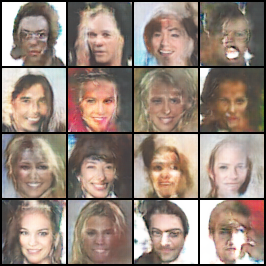

In [8]:
from IPython.display import Image
Image("/home/jehyuk/GenerativeModels/GAN/results/WGAN/CelebA/WGAN_epoch020.png", width = 256, height=256)

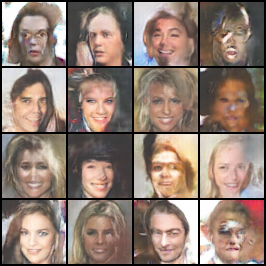

In [9]:
Image("/home/jehyuk/GenerativeModels/GAN/results/WGAN/CelebA/WGAN_epoch040.png", width = 256, height=256)

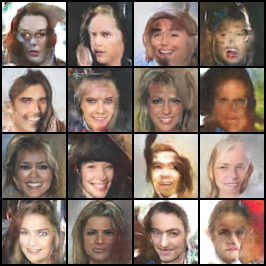

In [10]:
Image("/home/jehyuk/GenerativeModels/GAN/results/WGAN/CelebA/WGAN_epoch060.png", width = 256, height=256)

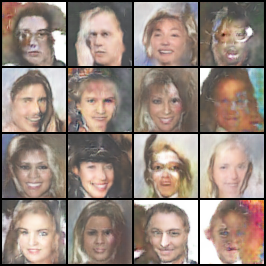

In [11]:
Image("/home/jehyuk/GenerativeModels/GAN/results/WGAN/CelebA/WGAN_epoch080.png", width = 256, height=256)

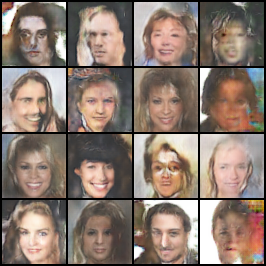

In [12]:
Image("/home/jehyuk/GenerativeModels/GAN/results/WGAN/CelebA/WGAN_epoch100.png", width = 256, height=256)